In [ ]:
import pandas as pd
import numpy as np
import math
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM,Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 
import random
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('Loading model...')
model = tf.keras.models.load_model('/content/drive/My Drive/SwitchPolarity/cncc_lstm.h5')
print('Model loaded.')


# Load S2 Polarity Switch data
print('Loading ground truth data...')
df = pd.read_csv('/content/drive/My Drive/SwitchPolarity/S2_S3.csv')
df['volt'] = df['ef']/1000
print('Data loaded. Head of dataframe:')
df.tail()

Loading model...
Model loaded.
Loading ground truth data...
Data loaded. Head of dataframe:


,Unnamed: 0,track,slice,x,y,cum_dir,ef,set,volt
695,695,25,24,56.130007,-68.319708,0.358219,0,2,0.0
696,696,25,25,56.417931,-67.160225,0.241002,0,2,0.0
697,697,25,26,55.724202,-61.916557,-0.131156,0,2,0.0
698,698,25,27,56.542025,-62.008507,0.993739,0,2,0.0
699,699,25,28,54.045304,-63.397362,-0.873891,0,2,0.0


In [ ]:
#creates dataset to use for training/testing - updated scaling
def create_dataset(df, lookback=20, in_cols=['volt', 'cum_dir'], out_cols='cum_dir', tracks=(1,26)):
    trainX, trainY, testX, testY = [], [], [], [] #lists of training and testing inputs/outputs
    for track in range(tracks[0], tracks[1]):
        cell = df.loc[(df["track"] == track)] #all rows of data pertaining to this cell
        cell = cell[in_cols] #reduce it to our columns of interest
        for i in range(len(cell)-lookback):
            trainX.append(cell[i:i+lookback])
        cell = cell[out_cols]
        for i in range(len(cell)-lookback):
            trainY.append(cell[i+lookback:i+lookback+1])

    trainX = np.array(list(map(lambda x: x.to_numpy(), trainX)))
    trainY = np.array(list(map(lambda x: x.to_numpy(), trainY)))
    return np.array(trainX), np.array(trainY)

In [ ]:
trainX, trainY = create_dataset(df,tracks=(1,11))
valX, valY = create_dataset(df, tracks=(11,21))
testX, testY = create_dataset(df, tracks=(21,26))

In [ ]:
#transfer learning using cncc model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=20, batch_size=1, verbose=1)
model.save("models/reversal_lstm_transfer/model{}.h5".format(1))
print("Saved model{}.h5 to disk".format(1))

Epoch 1/20
80/80 [==============================] - 3s 18ms/step - loss: 0.7637 - val_loss: 1.2216
Epoch 2/20
80/80 [==============================] - 1s 11ms/step - loss: 0.6470 - val_loss: 1.1663
Epoch 3/20
80/80 [==============================] - 1s 11ms/step - loss: 0.5325 - val_loss: 1.1159
Epoch 4/20
80/80 [==============================] - 1s 10ms/step - loss: 0.4611 - val_loss: 1.0688
Epoch 5/20
80/80 [==============================] - 1s 12ms/step - loss: 0.3930 - val_loss: 1.0461
Epoch 6/20
80/80 [==============================] - 1s 11ms/step - loss: 0.3401 - val_loss: 1.0399
Epoch 7/20
80/80 [==============================] - 1s 11ms/step - loss: 0.2840 - val_loss: 1.0443
Epoch 8/20
80/80 [==============================] - 1s 11ms/step - loss: 0.2479 - val_loss: 1.0398
Epoch 9/20
80/80 [==============================] - 1s 11ms/step - loss: 0.1980 - val_loss: 1.0286
Epoch 10/20
80/80 [==============================] - 1s 12ms/step - loss: 0.1530 - val_loss: 1.0344
Epoch 11/

In [ ]:
#Predict on training, validation, and test sets
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

In [ ]:
#Calculate RMSEs
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Training RMSE: {}'.format(trainScore))
valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Validation RMSE: {}'.format(valScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Testing RMSE: {}'.format(testScore))

Training RMSE: 0.13796129277419547
Validation RMSE: 1.040347931865772
Testing RMSE: 0.7570153017387038


In [ ]:
print('Writing results for model {}'.format(1))
maxtrack = int(max(df['track']))
for track in range(1, maxtrack+1):
    cell = df.loc[(df['track']==track)]
    if len(cell)==0:
        continue
    maxslice = max(df.loc[(df['track']==track), 'slice'])
    minslice = min(df.loc[(df['track']==track), 'slice'])
    for sl in range(int(minslice+20),int(maxslice-minslice+2)):
        x = cell.loc[(cell['slice']>sl-21) & (cell['slice']<sl)]
        x = x[['volt','cum_dir']].to_numpy()
        x=x.reshape(1, 20, 2)
        df.loc[(df['track']==track) & (df['slice']==sl), 'pred_dir{}'.format(1)] = model.predict(x)
            
df['pred_error{}'.format(1)] = df['pred_dir{}'.format(1)] - df['cum_dir']

Writing results for model 1


In [ ]:
#Saving the predictions to csv
df.to_csv(r'/content/drive/My Drive/SwitchPolarity/switchPolarity_predictions.csv', index=False)
df.head(30)

,Unnamed: 0,track,slice,x,y,cum_dir,ef,set,volt,pred_dir1,pred_error1
0,0,1,1,0.000000,0.000000,0.000000,0,2,0.0,NaN,NaN
1,1,1,2,3.208460,-0.187115,0.998304,0,2,0.0,NaN,NaN
2,2,1,3,-0.710196,0.528954,-0.983711,0,2,0.0,NaN,NaN
3,3,1,4,-1.811726,0.059887,-0.920055,0,2,0.0,NaN,NaN
4,4,1,5,-0.115205,-0.075329,0.996839,0,2,0.0,NaN,NaN
5,5,1,6,5.799938,0.544160,0.994561,0,2,0.0,NaN,NaN
6,6,1,7,16.032835,2.988950,0.972626,0,2,0.0,NaN,NaN
7,7,1,8,27.241468,5.213829,0.980863,0,2,0.0,NaN,NaN
8,8,1,9,36.513283,10.619072,0.863913,0,2,0.0,NaN,NaN
9,9,1,10,41.520762,13.326704,0.879641,0,2,0.0,NaN,NaN


Text(0, 0.5, 'Directedness')

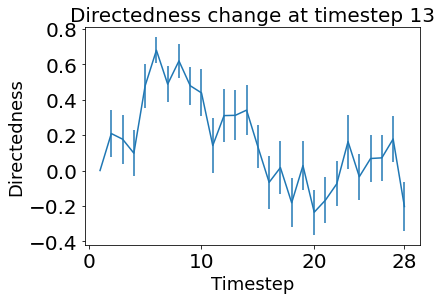

In [ ]:
#Plot Directedness
#fig = plt.figure(figsize=(8,6),dpi=180)
plt.errorbar(df['slice'].unique(),df.groupby(['slice']).mean()['cum_dir'],
            yerr = df.groupby(['slice']).sem()['cum_dir'])
plt.title('Directedness change at timestep 13',fontsize=20)
plt.xticks([0,10,20,28],fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Timestep',fontsize=18)
plt.ylabel('Directedness',fontsize=18)



In [ ]:
df.groupby(['slice']).sem()['cum_dir']

[0.000000, 0.133067,0.138568,0.130609,0.123712,0.073532,0.101625,0.095649, 0.107637,0.132463,0.157625,0.147752,0.141207,0.143293,0.120476,
0.149277,0.150742,0.138872,0.138626,0.128290,0.132345,0.126642,0.153050,0.130137,0.134596,0.129261,0.132460,0.140337]

slice
1     0.000000
2     0.133067
3     0.138568
4     0.130609
5     0.123712
6     0.073532
7     0.101625
8     0.095649
9     0.107637
10    0.132463
11    0.157625
12    0.147752
13    0.141207
14    0.143293
15    0.120476
16    0.149277
17    0.150742
18    0.138872
19    0.138626
20    0.128290
21    0.132345
22    0.126642
23    0.153050
24    0.130137
25    0.134596
26    0.129261
27    0.132460
28    0.140337
Name: cum_dir, dtype: float64

In [ ]:
df4=pd.read_csv('/content/drive/My Drive/SwitchPolarity/switchPolarity_predictions.csv')
err4 = []
cells4 = df4[(df4['pred_dir1'].notna()) & (df4['track']>20)]

In [ ]:
print(cells4[cells4['track']==25]['pred_error1'])


692    1.105290
693   -0.193011
694   -0.116021
695   -0.084165
696   -0.379552
697   -0.121575
698   -1.140147
699    1.445543
Name: pred_error1, dtype: float64


In [ ]:
##Plot the directedness values vs predicted values

df4.head()


,Unnamed: 0,track,slice,x,y,cum_dir,ef,set,volt,pred_dir1,pred_error1
0,0,1,1,0.000000,0.000000,0.000000,0,2,0.0,NaN,NaN
1,1,1,2,3.208460,-0.187115,0.998304,0,2,0.0,NaN,NaN
2,2,1,3,-0.710196,0.528954,-0.983711,0,2,0.0,NaN,NaN
3,3,1,4,-1.811726,0.059887,-0.920055,0,2,0.0,NaN,NaN
4,4,1,5,-0.115205,-0.075329,0.996839,0,2,0.0,NaN,NaN


In [ ]:
#for t in range(1,25):
#print(plt.plot(df4.cum_dir[df4.slice[20:27]][df4.track == 2]))

#print(df4['cum_dir'].loc[(df4['track'] == 2) & (df4['slice'].iloc[:])])
#print(df4.loc[df4['pred_error1'].notna()])
#fig = plt.figure(figsize=(10,6))

#ax = fig.add_subplot()
#for t in range(1,25):
  #plt.plot(df4['cum_dir'].loc[(df4['track'] == t) & df4['pred_error1'].notna()])
  #cell = df4.loc[(df4['track']== t) & df4['pred_error1'].notna()]
  #ax.plot(cell['slice']-1,cell['cum_dir'])


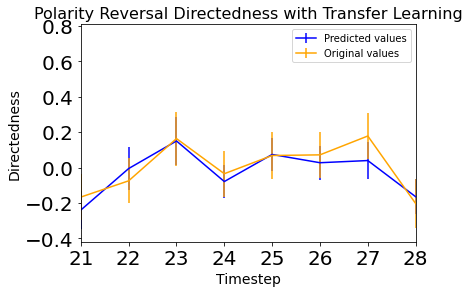

In [ ]:
plt.errorbar(df4['slice'].unique(),df4.groupby(['slice']).mean()['pred_dir1'],
            yerr = df4.groupby(['slice']).sem()['pred_dir1'],color = 'b', label = 'Predicted values')
plt.errorbar(df4['slice'].unique(),df4.groupby(['slice']).mean()['cum_dir'],
            yerr = df4.groupby(['slice']).sem()['cum_dir'] , color = 'orange', label = 'Original values')
#plt.xticks([21,28],fontsize=20)
plt.xticks(np.arange(21, 29, 1.0),fontsize=20)
plt.xlim(21,28)
plt.yticks(fontsize=20)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Directedness',fontsize=14)
plt.title('Polarity Reversal Directedness with Transfer Learning',fontsize=16)
plt.legend()


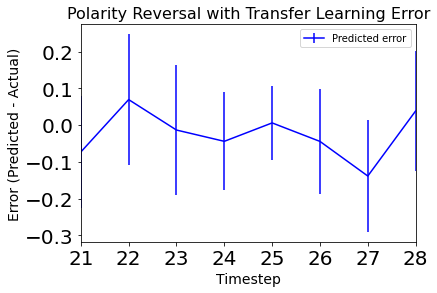

In [ ]:
plt.errorbar(df4['slice'].unique(),df4.groupby(['slice']).mean()['pred_error1'],
            yerr = df4.groupby(['slice']).sem()['pred_error1'],color = 'b', label = 'Predicted error')
#plt.xticks([21,28],fontsize=20)
plt.xticks(np.arange(21, 29, 1.0),fontsize=20)
plt.xlim(21,28)
plt.yticks(fontsize=20)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Error (Predicted - Actual)',fontsize=14)
plt.title('Polarity Reversal with Transfer Learning Error',fontsize=16)
plt.legend()

In [ ]:
df4.groupby(['slice']).sem()['pred_error1']

slice
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21    0.152543
22    0.177927
23    0.175909
24    0.133003
25    0.100310
26    0.142892
27    0.152174
28    0.162459
Name: pred_error1, dtype: float64

In [ ]:
# Not using transfer learning, building a model to predict

models = [] #list of models 
for i in range(3):
    #build the model
    print('Training model number {}'.format(i))
    model = Sequential()
    model.add(LSTM(80, input_shape=(20, 2)))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=25, batch_size=1, verbose=1)
    models.append(model)
        
    model.save("reversal_lstm/model{}.h5".format(i))
    print("Saved model {} to disk".format(i))

    #Predict on training, validation, and test sets
    trainPredict = model.predict(trainX)
    valPredict = model.predict(valX)
    testPredict = model.predict(testX)

    #Calculate RMSEs
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Training RMSE: {}'.format(trainScore))
    valScore = math.sqrt(mean_squared_error(valY, valPredict))
    print('Validation RMSE: {}'.format(valScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Testing RMSE: {}'.format(testScore))

Training model number 0
Epoch 1/25
80/80 [==============================] - 3s 17ms/step - loss: 0.3946 - val_loss: 0.5996
Epoch 2/25
80/80 [==============================] - 1s 10ms/step - loss: 0.3839 - val_loss: 0.6020
Epoch 3/25
80/80 [==============================] - 1s 10ms/step - loss: 0.3787 - val_loss: 0.6114
Epoch 4/25
80/80 [==============================] - 1s 10ms/step - loss: 0.3803 - val_loss: 0.6158
Epoch 5/25
80/80 [==============================] - 1s 10ms/step - loss: 0.3772 - val_loss: 0.6119
Epoch 6/25
80/80 [==============================] - 1s 10ms/step - loss: 0.3779 - val_loss: 0.6138
Epoch 7/25
80/80 [==============================] - 1s 11ms/step - loss: 0.3753 - val_loss: 0.6203
Epoch 8/25
80/80 [==============================] - 1s 12ms/step - loss: 0.3756 - val_loss: 0.6300
Epoch 9/25
80/80 [==============================] - 1s 11ms/step - loss: 0.3733 - val_loss: 0.6306
Epoch 10/25
80/80 [==============================] - 1s 11ms/step - loss: 0.3712 - va

In [ ]:
 #Predict on training, validation, and test sets
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

#Calculate RMSEs
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Training RMSE: {}'.format(trainScore))
valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Validation RMSE: {}'.format(valScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Testing RMSE: {}'.format(testScore))

print('Writing results for model {}'.format(i))
maxtrack = int(max(df['track']))


Training RMSE: 0.5880596059781782
Validation RMSE: 0.7949168705328639
Testing RMSE: 0.59673229694449
Writing results for model 2


In [ ]:
for track in range(1, maxtrack+1):

  cell = df.loc[(df['track']==track)]

  if len(cell)== 0:
    continue
  maxslice = max(df.loc[(df['track']==track), 'slice'])
  minslice = min(df.loc[(df['track']==track), 'slice'])
  for sl in range(int(minslice+20),int(maxslice-minslice+2)):
    x = cell.loc[(cell['slice'] > sl -21) & (cell['slice']< sl)]
    x = x[['volt','cum_dir']].to_numpy()
    x=x.reshape(1, 20, 2)
    df.loc[(df['track']==track) & (df['slice']==sl), 'pred_dir{}'.format(i)] = model.predict(x)
     
df['pred_error{}'.format(i)] = df['pred_dir{}'.format(i)] - df['cum_dir']
df.to_csv('/content/drive/My Drive/SwitchPolarity/cncc_lstm_reversal_predictions.csv', index=False)
df.head(40)

,Unnamed: 0,track,slice,x,y,cum_dir,ef,set,volt,pred_dir1,pred_error1,pred_dir2,pred_error2
0,0,1,1,0.000000,0.000000,0.000000,0,2,0.0,NaN,NaN,NaN,NaN
1,1,1,2,3.208460,-0.187115,0.998304,0,2,0.0,NaN,NaN,NaN,NaN
2,2,1,3,-0.710196,0.528954,-0.983711,0,2,0.0,NaN,NaN,NaN,NaN
3,3,1,4,-1.811726,0.059887,-0.920055,0,2,0.0,NaN,NaN,NaN,NaN
4,4,1,5,-0.115205,-0.075329,0.996839,0,2,0.0,NaN,NaN,NaN,NaN
5,5,1,6,5.799938,0.544160,0.994561,0,2,0.0,NaN,NaN,NaN,NaN
6,6,1,7,16.032835,2.988950,0.972626,0,2,0.0,NaN,NaN,NaN,NaN
7,7,1,8,27.241468,5.213829,0.980863,0,2,0.0,NaN,NaN,NaN,NaN
8,8,1,9,36.513283,10.619072,0.863913,0,2,0.0,NaN,NaN,NaN,NaN
9,9,1,10,41.520762,13.326704,0.879641,0,2,0.0,NaN,NaN,NaN,NaN


In [ ]:
df.head(30)
i = 0
for model in models:
  maxtrack = int(max(df['track']))
  for track in range(1, maxtrack+1):
    cell = df.loc[(df['track']==track)]
    if len(cell)==0:
      continue
    maxslice = max(df.loc[(df['track']==track), 'slice'])
    minslice = min(df.loc[(df['track']==track), 'slice'])
    for sl in range(int(minslice+20),int(maxslice-minslice+2)):
      x = cell.loc[(cell['slice']>sl-21) & (cell['slice']<sl)]
      x = x[['volt','cum_dir']].to_numpy()
      x=x.reshape(1, 20, 2)
      df.loc[(df['track']==track) & (df['slice']==sl), 'pred_dir{}'.format(i)] = model.predict(x)
    df['pred_error{}'.format(i)] = df['pred_dir{}'.format(i)] - df['cum_dir']
    i+=1
df.to_csv('reversal_predictions_noTL.csv', index=False)



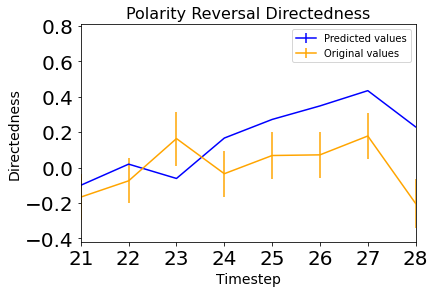

In [ ]:
df2=pd.read_csv('reversal_predictions_noTL.csv')
err2 = []
cells2 = df2[(df2['pred_dir0'].notna()) & (df2['track']>20)]


plt.errorbar(df2['slice'].unique(),df2.groupby(['slice']).mean()['pred_dir0'],
            yerr = df2.groupby(['slice']).sem()['pred_dir0'],color = 'b', label = 'Predicted values')
plt.errorbar(df2['slice'].unique(),df2.groupby(['slice']).mean()['cum_dir'],
            yerr = df2.groupby(['slice']).sem()['cum_dir'] , color = 'orange', label = 'Original values')
#plt.xticks([21,28],fontsize=20)
plt.xticks(np.arange(21, 29, 1.0),fontsize=20)
plt.xlim(21,28)
plt.yticks(fontsize=20)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Directedness',fontsize=14)
plt.title('Polarity Reversal Directedness',fontsize=16)
plt.legend()

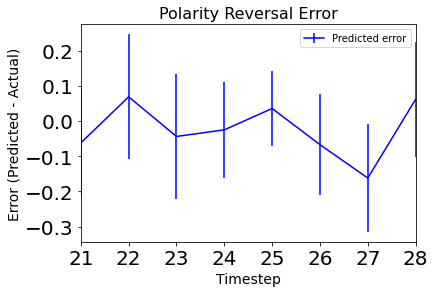

In [ ]:
plt.errorbar(df2['slice'].unique(),df2.groupby(['slice']).mean()['pred_error1'],
            yerr = df2.groupby(['slice']).sem()['pred_error1'],color = 'b', label = 'Predicted error')
#plt.xticks([21,28],fontsize=20)
plt.xticks(np.arange(21, 29, 1.0),fontsize=20)
plt.xlim(21,28)
plt.yticks(fontsize=20)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Error (Predicted - Actual)',fontsize=14)
plt.title('Polarity Reversal Error',fontsize=16)
plt.legend()

In [ ]:
df2.groupby(['slice']).sem()['pred_error1']

slice
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21    0.152882
22    0.177935
23    0.177823
24    0.135877
25    0.106655
26    0.143744
27    0.153124
28    0.164020
Name: pred_error1, dtype: float64

median: 0.153003, IQR: 0.031111, mean: 0.15150750000000002, standard deviation: 0.023507793522270743
median: 0.1523585, IQR: 0.0312365, mean: 0.149652125, standard deviation: 0.025142914517030726


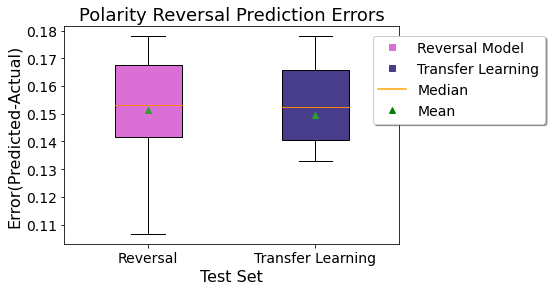

In [ ]:
#REVERSAL BOXPLOT
import statistics

df_rev= df2#load reversal model data
df_trans=df4 #load transfer learning data

#errors on the respective test sets
err_rev = []
err_trans = []

       
# Get errors from reversal tests

#base model on reversal

#reversal model
test = df_rev[(df_rev['pred_dir0'].notna())]
for track in test['track'].unique():
    for i in range(3):
        cell_errors = test[test['track']==track]['pred_error{}'.format(i)]
        err_rev.append(math.sqrt(mean_squared_error(cell_errors, np.zeros(len(cell_errors)))))
            
#transfer learning model
test = df_trans[(df_trans['pred_dir1'].notna())]
for track in test['track'].unique():
    cell_errors = test[test['track']==track]['pred_error{}'.format(1)]
    err_trans.append(math.sqrt(mean_squared_error(cell_errors, np.zeros(len(cell_errors)))))

#err_rev = [0.46733832007558346, 0.1206887787257978, 0.3375872463389019]
#err_trans = [0.06733832007558346, 0.1506887787257978, 0.1728613826514627,0.26358704242989186 ]
err_trans = [ 0.152543,0.177927, 0.175909,0.133003,0.100310, 0.142892,0.152174,0.162459]
err_rev = [0.152882,0.177935,0.177823,0.135877,0.106655,0.143744,0.153124,0.164020 ]


errors = [err_rev,err_trans]
    
fig, ax = plt.subplots()
ax.set_title('Polarity Reversal Prediction Errors', fontsize=18)
ax.set_xlabel('Test Set', fontsize=16)
ax.set_ylabel('Error(Predicted-Actual)', fontsize=16)
#fig.set_size_inches(14, 8) # set figure size

boxes = ax.boxplot(errors, showmeans=True, showfliers=False, widths=0.4, patch_artist=True)
plt.xticks([1,2], labels=[ 'Reversal', 'Transfer Learning'], fontsize=14)
plt.yticks(fontsize=14)

#colors
rev_color = 'orchid'
trans_color = 'darkslateblue'
colors = [rev_color, trans_color]
for patch, color in zip(boxes['boxes'], colors):
    patch.set_facecolor(color)
    
#legend information
rev_label, = ax.plot([],'s',color=rev_color)
trans_label, = ax.plot([],'s',color=trans_color)
median_label, = ax.plot([],color='orange')
mean_label, = ax.plot([],'^',color='green')
lgd=ax.legend(
    [rev_label,trans_label,median_label,mean_label],
    ['Reversal Model','Transfer Learning','Median','Mean'],
    bbox_to_anchor=(0.9,0.99), fancybox=True, shadow=True, loc='upper left', fontsize=14)
    
#plt.savefig('figures/reversal_boxplot.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight') #save the figure

for error in errors:
    Q1 = np.percentile(error, 25, interpolation = 'midpoint') 
    Q3 = np.percentile(error, 75, interpolation = 'midpoint') 
    IQR = Q3 - Q1 
    print('median: {}, IQR: {}, mean: {}, standard deviation: {}'.format(statistics.median(error), IQR, statistics.mean(error), statistics.stdev(error)))

In [ ]:
err_rev

[0.46733832007558346, 0.1206887787257978, 0.5375872463389019]

In [ ]:
err_trans

[0.1206887787257978,
 0.11455159654989411,
 0.08872641668642303,
 0.16196187777492121,
 0.060956754634135205,
 0.16358704242989186,
 0.10262657450716081,
 0.1728613826514627,
 0.16698623378407,
 0.1725318150994541,
 1.1975670019792055,
 1.389126569310172,
 0.9966189227669313,
 1.1460338108637804,
 1.1471769373739893,
 0.7473230316012927,
 0.740414200019863,
 1.1328395349612057,
 0.9778416674821059,
 0.7003831879240954,
 0.9921789754061179,
 0.6081220570385322,
 0.5128927266502817,
 0.8028642523707862,
 0.7768393234111445]

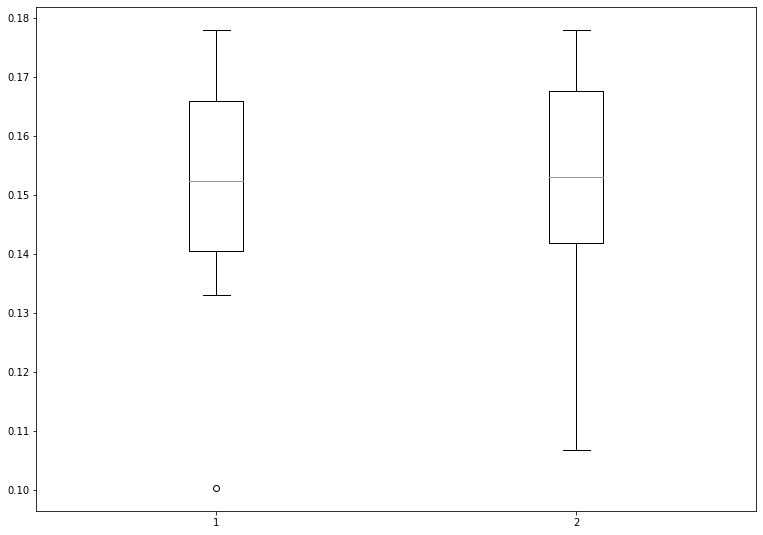

In [ ]:
data_1 = [ 0.152543,0.177927, 0.175909,0.133003,0.100310, 0.142892,0.152174,0.162459]
data_2 = [0.152882,0.177935,0.177823,0.135877,0.106655,0.143744,0.153124,0.164020 ]

data = [data_1, data_2]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,  1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()